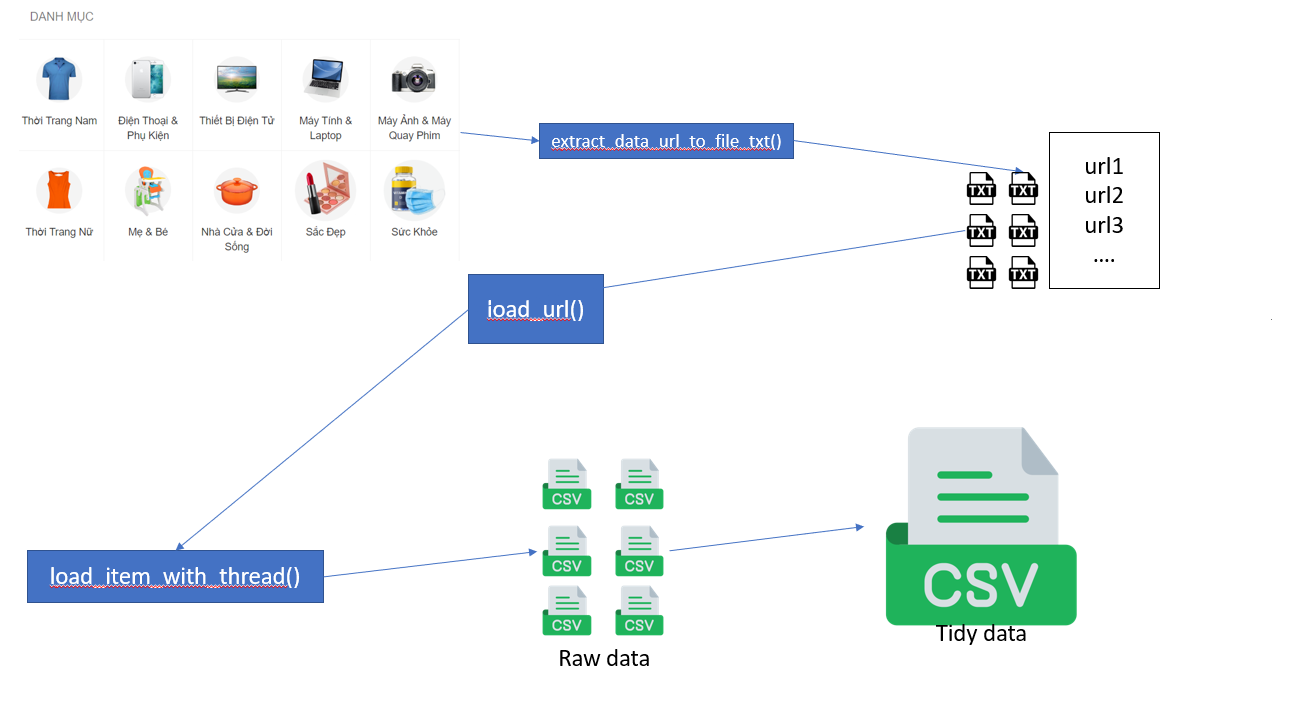

# Import, Settings, switches and global functions

## Import library & Settings

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from webdriver_manager.microsoft import EdgeChromiumDriverManager
from selenium.webdriver.edge.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from concurrent.futures import ThreadPoolExecutor
import threading
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import csv
import time
import re

In [ ]:
# Download edge driver
driver = webdriver.Edge(EdgeChromiumDriverManager().install())

## Functions

### Create Webdriver
**note**: opt.add_argument("--headless")
<br>`create_webdriver(url)`

In [ ]:
def create_webdriver(url):
    opt = Options()
    opt.add_argument("--headless")
    driver = webdriver.Edge(EdgeChromiumDriverManager().install(), options=opt)
    #driver = webdriver.Edge(EdgeChromiumDriverManager().install())
    driver.get(url)
    driver.maximize_window()
    #driver.implicitly_wait(7)
    return driver

### Write URLs to File txt

#### Scroll down page
`__scroll_down_page(driver, speed=5)`

In [ ]:
def __scroll_down_page(driver, speed=5):
    current_scroll_position, new_height= 0, 1
    while current_scroll_position <= new_height:
        current_scroll_position += speed
        driver.execute_script("window.scrollTo(0, {});".format(current_scroll_position))
        new_height = driver.execute_script("return document.body.scrollHeight")

#### Crawl URL
`crawl_url(url, file_number)`: write urls to file_number

In [ ]:
def crawl_url(url, file_number):
    
    # page_url = url
    # driver = webdriver.Edge(EdgeChromiumDriverManager().install())
    # driver.get(page_url)
    # driver.maximize_window()
    # driver.implicitly_wait(7)
    # time.sleep(5)
    driver = create_webdriver(url)
    driver.implicitly_wait(30)
    __scroll_down_page(driver)
    items = driver.find_elements(By.CLASS_NAME, "col-xs-2-4.shopee-search-item-result__item")
    
    file_name = 'item_' + str(file_number) + '_url.txt'
    f = open(file_name,'w')
    for item in items:
        link = item.find_element(By.TAG_NAME, "a").get_attribute('href')
        f.write(link)
        f.write('\n')
        
    f.close()
    driver.quit()

#### Extract data
`extract_data_url_to_file_txt()`

In [ ]:
def extract_data_url_to_file_txt():
    url = input("URL Shopee: ")
    file_number = input("File number: ")
    crawl_url(url, file_number)

### Extract Comments with option rate stars

#### Handle comments and rates
`handle_comments_rates(driver)`

In [ ]:
def handle_comments_rates(driver):
    list_comments = []
    # blockcomments = driver.find_elements(By.CLASS_NAME, "Rk6V\+3")
    # blockrating = driver.find_elements(By.CLASS_NAME, "shopee-product-rating__rating")
    
    wait = WebDriverWait(driver, 60)
    blockcomments = wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "Rk6V\+3")))
    
    blockrating = driver.find_elements(By.CLASS_NAME, "shopee-product-rating__rating")
    
    for comment, rate in zip(blockcomments, blockrating):
        try:
            cmt = comment.find_element(By.CSS_SELECTOR, "div:last-of-type").text
        except:
            cmt = comment.text
            
        rte = len(rate.find_elements(By.CSS_SELECTOR, "svg.shopee-svg-icon.icon-rating-solid--active.icon-rating-solid"))
        list_comments.append((cmt,rte))
    
    return list_comments

#### Crawl comment options stars function
`crawl_comment_option_stars(driver, url, choice_star)`

In [ ]:
def crawl_comment_option_stars(driver, url, choice_star):

    #[2]:5s, [3]:4s, [4]:3s, [5]:2s, [6]:1s
    #choice_star = 7 - int(option_star)
    
    wait = WebDriverWait(driver, 30)
    stars =  wait.until(EC.presence_of_element_located((By.CLASS_NAME, "product-rating-overview__filters")))
    
    #stars = driver.find_element(By.CLASS_NAME, "product-rating-overview__filters")
    choice_star = "div[" + str(choice_star) + "]"
    stars.find_element(By.XPATH, choice_star).click()

    list_comment = handle_comments_rates(driver)
    
    return list_comment

### Read urls from txt file
`load_url()`

In [1]:
def load_url():
    file_name = input('File number')
    no_data = re.findall(r'\d+', file_name)[0]
    lst_url = []
    try:
        with open(file_name) as f:
            for line in f:
                lst_url.append(line)
    except:
        print("Error load_url, file cannot be opened", file_name)
        exit()
    return lst_url, no_data

# Combinate Functions and Extract Data

### Scrape from URL
`scrape_url(item_url, choice_stars, file_name)`

In [ ]:
def scrape_url(item_url, choice_stars, file_name):
    driver = create_webdriver(item_url)
    wait = WebDriverWait(driver, 30)
    wait.until(EC.element_to_be_clickable((By.CLASS_NAME, "flex.jgUbWJ")))
    driver.find_element(By.CLASS_NAME, "flex.jgUbWJ").click()
    
    comment_options_list = []
    
    for star in choice_stars:
        comments = crawl_comment_option_stars(driver, item_url, star)
        comment_options_list.extend(comments)
        
    with open(file_name, 'a', encoding='utf8', newline='') as f:
        writer = csv.writer(f, delimiter=',', skipinitialspace=True)
        for comment_tuple in comment_options_list:
            writer.writerow(comment_tuple)
    
    driver.quit()
    #print('Done scraping:', item_url)

### Load item with thread
`load_item_with_thread(lst_url, file_number)`

In [1]:
def load_item_with_thread(lst_url, file_number):
    
    choice_stars_transform = ['2','3','4','5','6']
    file_name = 'data_' + str(file_number) + '.csv'
    count = 1
    threads = []

    with ThreadPoolExecutor(max_workers=3) as executor:
        for i, item_url in enumerate(lst_url):
            if (i%5 == 0) & (i!=0):
                time.sleep(75)
            try:
                thread = executor.submit(scrape_url, item_url, choice_stars_transform, file_name)
                threads.append(thread)
                # Wait for a delay between each request to avoid overloading the server
                time.sleep(7)
            except Exception as e:
                print(f"Error scraping URL {i}: {item_url}\nError message: {str(e)}")
        
    # Wait for all threads to complete before exiting the function
    for thread in threads:
        try:
            thread.result()
        except:
            continue

### Run it to extract comment and rates

In [ ]:
lst,num_file = load_url()

start_time = time.time()

load_item_with_thread(lst, num_file)

elapsed_time = time.time() - start_time
print("Time: ", elapsed_time)